<a href="https://colab.research.google.com/github/leisha-jain/demo3/blob/main/oilspilldetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
image_dir = "/content/drive/MyDrive/sos-dataset/dataset/train/sentinel/image/"
label_dir="/content/drive/MyDrive/sos-dataset/dataset/train/sentinel/label/"

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import cv2


In [ ]:
image_files=sorted(os.listdir(image_dir))
label_files=sorted(os.listdir(label_dir))
print("Total Images: ",len(image_files))
print("Total Labels: ",len(label_files))

Total Images:  3354
Total Labels:  3354


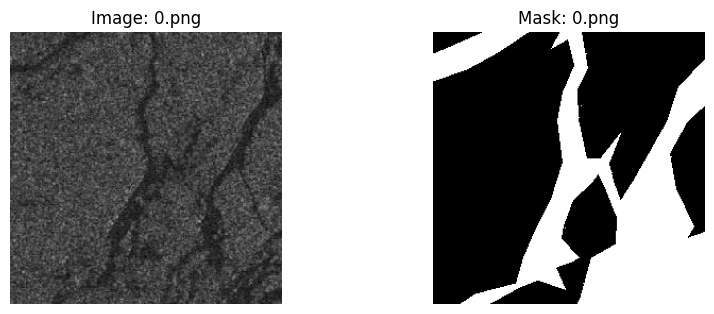

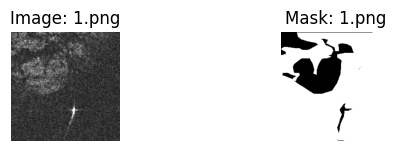

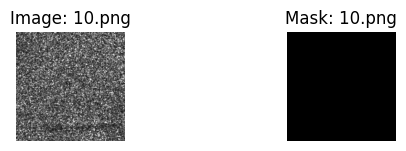

In [ ]:
def show_samples(num=3):
  plt.figure(figsize=(10, 4*num))

  for i in range (num):
    img_path=os.path.join(image_dir,image_files[i])
    label_path=os.path.join(label_dir,label_files[i])

    img=np.array(Image.open(img_path))
    label=np.array(Image.open(label_path))

    plt.subplot(num,2,2*i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Image: {image_files[i]}")
    plt.axis('off')



        # show mask
    plt.subplot(num, 2, 2*i+2)
    plt.imshow(label, cmap='gray')
    plt.title(f"Mask: {label_files[i]}")
    plt.axis('off')

    plt.show()

show_samples(3)


In [ ]:
#check image and label dimensions
sample_img=np.array(Image.open(os.path.join(image_dir,image_files[0])))
sample_label=np.array(Image.open(os.path.join(label_dir,label_files[0])))
print("Image Shape: ",sample_img.shape)
print("Label Shape: ",sample_label.shape)

Image Shape:  (256, 256, 3)
Label Shape:  (256, 256, 3)


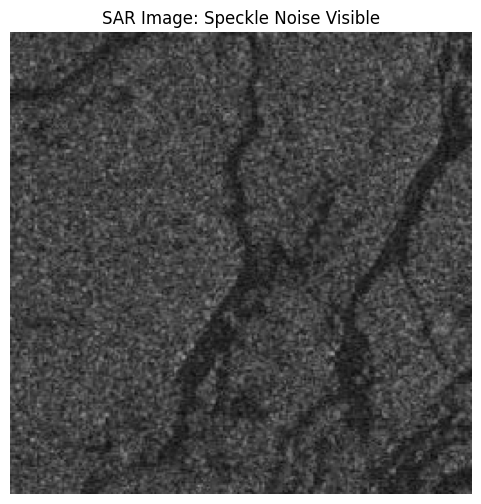

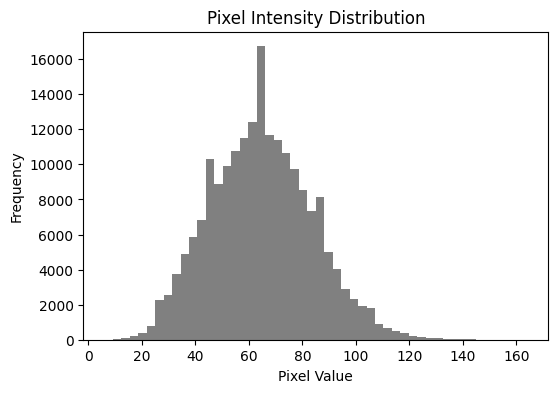

In [ ]:
#observe SAR noise and pixel intensity
plt.figure(figsize=(6,6))
plt.imshow(sample_img,cmap='gray')
plt.title("SAR Image: Speckle Noise Visible")
plt.axis('off')
plt.show()

plt.figure(figsize=(6,4))
plt.hist(sample_img.flatten(), bins=50, color="gray")
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()



In [ ]:
#Preprocessing

In [ ]:
IMG_SIZE=(256,256)

def preprocess_img(img):
    if isinstance(img, np.ndarray):
        img = Image.fromarray(img)
    img=img.resize(IMG_SIZE)
    img_np=np.array(img)
    img_np=img_np/255.0
    img_np=cv2.medianBlur((img_np*255).astype(np.uint8),3)/255.0
    return img_np


def preprocess_label(label):
  if isinstance(label, np.ndarray):
      label = Image.fromarray(label)
  label=label.resize(IMG_SIZE)
  label_np=np.array(label)
  label_np = (label_np > 0).astype(np.uint8)
  return label_np

def augment_img(img):
  return np.fliplr(img)

def augment_label(label):
  return np.fliplr(label)

preprocessed_img=preprocess_img(sample_img)
preprocessed_label=preprocess_label(sample_label)

aug_img=augment_img(preprocessed_img)
aug_label=augment_label(preprocessed_label)

In [ ]:
#module 3: model development

In [ ]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
  def __init__(self,in_channels,out_channels):
    super(DoubleConv,self).__init__()
    self.net=nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )
  def forward(self,x):
    return self.net(x)


class UNet(nn.Module):
  def __init__(self,in_channels=3,out_channels=1):
    super(UNet,self).__init__()

    self.enc1=DoubleConv(in_channels,64)
    self.enc2=DoubleConv(64,128)
    self.enc3=DoubleConv(128,256)
    self.enc4=DoubleConv(256,512)

    self.pool=nn.MaxPool2d(2)

    self.bottleneck=DoubleConv(512,1024)

    self.up4=nn.ConvTranspose2d(1024,512,kernel_size=2,stride=2)
    self.dec4=DoubleConv(1024,512)

    self.up3=nn.ConvTranspose2d(512,256,kernel_size=2,stride=2)
    self.dec3=DoubleConv(512,256)

    self.up2=nn.ConvTranspose2d(256,128,kernel_size=2,stride=2)
    self.dec2=DoubleConv(256,128)

    self.up1=nn.ConvTranspose2d(128,64,kernel_size=2,stride=2)
    self.dec1=DoubleConv(128,64)

    self.final_cov=nn.Conv2d(64,out_channels,kernel_size=1)

  def forward(self,x):
    e1=self.enc1(x)
    p1=self.pool(e1)

    e2=self.enc2(p1)
    p2=self.pool(e2)

    e3=self.enc3(p2)
    p3=self.pool(e3)

    e4=self.enc4(p3)
    p4=self.pool(e4)

    b=self.bottleneck(p4)

    u4=self.up4(b)
    u4=torch.cat((u4,e4),dim=1)
    d4=self.dec4(u4)

    u3=self.up3(d4)
    u3=torch.cat((u3,e3),dim=1)
    d3=self.dec3(u3)

    u2=self.up2(d3)
    u2=torch.cat((u2,e2),dim=1)
    d2=self.dec2(u2)

    u1=self.up1(d2)
    u1=torch.cat((u1,e1),dim=1)
    d1=self.dec1(u1)

    output=self.final_cov(d1)
    return output


#automatically detect number of input channels

if len(sample_img.shape)==2:
  in_channels=1
else:
  in_channels=sample_img.shape[2]

print("Detected input channels:", in_channels)
model = UNet(in_channels=in_channels, out_channels=1)



Detected input channels: 3


In [ ]:
class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, g):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi


class AttentionUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(AttentionUNet, self).__init__()

        # Encoder
        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)

        self.pool = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = DoubleConv(512, 1024)

        # Decoder
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, 2)
        self.att4 = AttentionGate(F_g=512, F_l=512, F_int=256)
        self.dec4 = DoubleConv(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.att3 = AttentionGate(F_g=256, F_l=256, F_int=128)
        self.dec3 = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.att2 = AttentionGate(F_g=128, F_l=128, F_int=64)
        self.dec2 = DoubleConv(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.att1 = AttentionGate(F_g=64, F_l=64, F_int=32)
        self.dec1 = DoubleConv(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        p1 = self.pool(e1)

        e2 = self.enc2(p1)
        p2 = self.pool(e2)

        e3 = self.enc3(p2)
        p3 = self.pool(e3)

        e4 = self.enc4(p3)
        p4 = self.pool(e4)

        # Bottleneck
        b = self.bottleneck(p4)

        # Decoder with Attention
        u4 = self.up4(b)
        e4 = self.att4(e4, u4)
        d4 = self.dec4(torch.cat([u4, e4], dim=1))

        u3 = self.up3(d4)
        e3 = self.att3(e3, u3)
        d3 = self.dec3(torch.cat([u3, e3], dim=1))

        u2 = self.up2(d3)
        e2 = self.att2(e2, u2)
        d2 = self.dec2(torch.cat([u2, e2], dim=1))

        u1 = self.up1(d2)
        e1 = self.att1(e1, u1)
        d1 = self.dec1(torch.cat([u1, e1], dim=1))

        return self.final_conv(d1)


In [ ]:
import random
from torch.utils.data import Dataset

class OilSpillDataset(Dataset):
    def __init__(self, image_dir, mask_dir, augment=False):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))
        self.augment = augment   # NEW FLAG

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.open(
            os.path.join(self.image_dir, self.images[idx])
        ).convert("L")

        mask = Image.open(
            os.path.join(self.mask_dir, self.masks[idx])
        ).convert("L")

        img = np.array(img)
        mask = np.array(mask)

        # -------------------------------
        # CHECK: no-spill image?
        # -------------------------------
        is_no_spill = mask.sum() == 0

        # -------------------------------
        # AUGMENT ONLY NO-SPILL IMAGES
        # -------------------------------
        if self.augment and is_no_spill:
            if random.random() > 0.5:
                img = np.fliplr(img)
            if random.random() > 0.5:
                img = np.flipud(img)
            if random.random() > 0.5:
                img = img + np.random.normal(0, 5, img.shape)

        # -------------------------------
        # PREPROCESS (UNCHANGED)
        # -------------------------------
        img = preprocess_img(img)
        mask = preprocess_label(mask)

        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        return img, mask


In [ ]:
from torch.utils.data import DataLoader

train_dataset = OilSpillDataset(
    "/content/drive/MyDrive/sos-dataset/dataset/test/sentinel/image/",
    "/content/drive/MyDrive/sos-dataset/dataset/test/sentinel/label/"
)

train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)



In [ ]:
#loss functions
def dice_loss(pred, target, smooth=1.):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    return 1 - (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
bce = nn.BCEWithLogitsLoss()

def combined_loss(pred, target):
    return bce(pred, target) + dice_loss(pred, target)


In [ ]:
#optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"

model = AttentionUNet(in_channels=1, out_channels=1).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
#training loop
epochs = 5

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for imgs, masks in train_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = combined_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(train_loader):.4f}")


Epoch [1/5], Loss: 0.9106
Epoch [2/5], Loss: 0.7268
Epoch [3/5], Loss: 0.6716
Epoch [4/5], Loss: 0.6595
Epoch [5/5], Loss: 0.6408


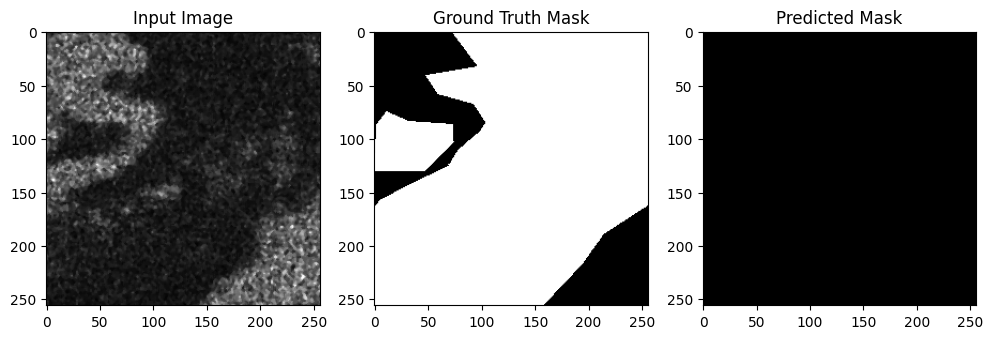

In [ ]:
#visualizing one prediction
model.eval()
img, mask = train_dataset[0]

with torch.no_grad():
    pred = torch.sigmoid(model(img.unsqueeze(0).to(device)))[0][0].cpu().numpy()

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img[0], cmap='gray')
plt.title("Input Image")

plt.subplot(1,3,2)
plt.imshow(mask[0], cmap='gray')
plt.title("Ground Truth Mask")

plt.subplot(1,3,3)
plt.imshow(pred > 0.5, cmap='gray')
plt.title("Predicted Mask")

plt.show()


In [ ]:
#module 4

In [ ]:
from torch.utils.data import random_split

full_dataset = OilSpillDataset(
    "/content/drive/MyDrive/sos-dataset/dataset/train/sentinel/image/",
    "/content/drive/MyDrive/sos-dataset/dataset/train/sentinel/label/"
)

print("Total samples:", len(full_dataset))

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_dataset, [train_size, val_size]
)

print("Train samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))


Total samples: 3354
Train samples: 2683
Validation samples: 671


In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
def dice_coeff(pred, target, smooth=1.):
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def iou_score(pred, target, smooth=1.):
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)

def precision(pred, target):
    pred = (pred > 0.5).float()
    tp = (pred * target).sum()
    fp = (pred * (1 - target)).sum()
    return tp / (tp + fp + 1e-8)

def recall(pred, target):
    pred = (pred > 0.5).float()
    tp = (pred * target).sum()
    fn = ((1 - pred) * target).sum()
    return tp / (tp + fn + 1e-8)


In [ ]:
print(device)
for imgs, masks in train_loader:
    print("HERE")
    break

model.eval()
with torch.no_grad():
    dummy = torch.randn(1, 1, 128, 128).to(device)
    _ = model(dummy)



cuda
HERE


In [ ]:
epochs = 20
scaler = torch.cuda.amp.GradScaler()

for epoch in range(epochs):

    # -------- TRAIN --------
    model.train()
    train_loss = 0

    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():   # ✅ AMP
            outputs = model(imgs)
            loss = combined_loss(outputs, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # -------- VALIDATION --------
    model.eval()
    val_loss = 0
    dice_total = 0
    iou_total = 0
    prec_total = 0
    rec_total = 0

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)

            outputs = model(imgs)
            val_loss += combined_loss(outputs, masks).item()

            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()   # ✅ THRESHOLD

            dice_total += dice_coeff(preds, masks).item()
            iou_total  += iou_score(preds, masks).item()
            prec_total += precision(preds, masks).item()
            rec_total  += recall(preds, masks).item()

    val_loss /= len(val_loader)

    print(
        f"Epoch [{epoch+1}/{epochs}] | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Dice: {dice_total/len(val_loader):.4f} | "
        f"IoU: {iou_total/len(val_loader):.4f} | "
        f"Precision: {prec_total/len(val_loader):.4f} | "
        f"Recall: {rec_total/len(val_loader):.4f}",
        flush=True   # ✅ PREVENTS DISCONNECT
    )


/tmp/ipython-input-2210372756.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipython-input-2210372756.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():   # ✅ AMP


Epoch [1/20] | Train Loss: 0.5545 | Val Loss: 0.5858 | Dice: 0.7855 | IoU: 0.6587 | Precision: 0.7841 | Recall: 0.8182
Epoch [2/20] | Train Loss: 0.5331 | Val Loss: 0.5143 | Dice: 0.8037 | IoU: 0.6822 | Precision: 0.7927 | Recall: 0.8400
Epoch [3/20] | Train Loss: 0.5195 | Val Loss: 0.5065 | Dice: 0.8010 | IoU: 0.6783 | Precision: 0.8387 | Recall: 0.7889
Epoch [4/20] | Train Loss: 0.5024 | Val Loss: 0.5723 | Dice: 0.7697 | IoU: 0.6404 | Precision: 0.8768 | Recall: 0.7150
Epoch [5/20] | Train Loss: 0.4901 | Val Loss: 0.5041 | Dice: 0.7996 | IoU: 0.6753 | Precision: 0.8269 | Recall: 0.7979
Epoch [6/20] | Train Loss: 0.4874 | Val Loss: 0.4998 | Dice: 0.8070 | IoU: 0.6856 | Precision: 0.8143 | Recall: 0.8208
Epoch [7/20] | Train Loss: 0.4799 | Val Loss: 0.5127 | Dice: 0.8078 | IoU: 0.6876 | Precision: 0.8038 | Recall: 0.8354
Epoch [8/20] | Train Loss: 0.4725 | Val Loss: 0.4761 | Dice: 0.8181 | IoU: 0.6995 | Precision: 0.7997 | Recall: 0.8533
Epoch [9/20] | Train Loss: 0.4616 | Val Loss: 0.

In [ ]:
torch.save(model.state_dict(), "attention_unet.pth")


In [ ]:
test_dataset = OilSpillDataset(
    "/content/drive/MyDrive/sos-dataset/dataset/test/sentinel/image/",
    "/content/drive/MyDrive/sos-dataset/dataset/test/sentinel/label/"
)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model.eval()
dice_scores = []
iou_scores = []

with torch.no_grad():
    for img, mask in test_loader:
        img, mask = img.to(device), mask.to(device)
        pred = torch.sigmoid(model(img))

        dice_scores.append(dice_coeff(pred, mask).item())
        iou_scores.append(iou_score(pred, mask).item())

print("Test Dice:", np.mean(dice_scores))
print("Test IoU:", np.mean(iou_scores))


Test Dice: 0.4424155474459978
Test IoU: 0.3472194680880258


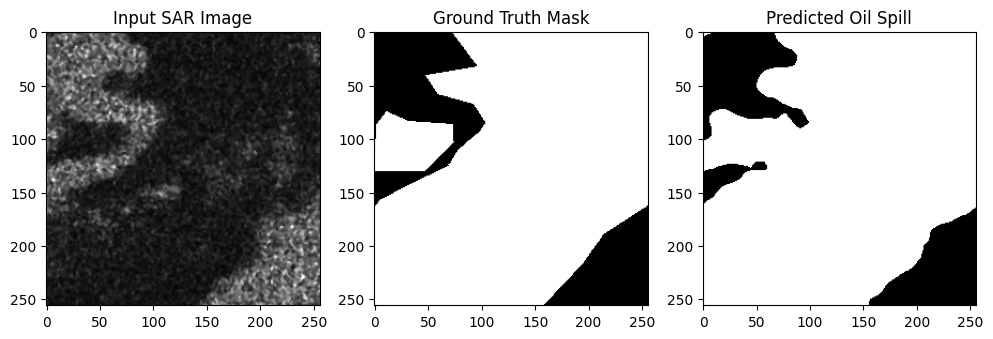

In [ ]:
img, mask = test_dataset[0]

model.eval()
with torch.no_grad():
    pred = torch.sigmoid(model(img.unsqueeze(0).to(device)))[0][0].cpu().numpy()

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img[0], cmap='gray')
plt.title("Input SAR Image")

plt.subplot(1,3,2)
plt.imshow(mask[0], cmap='gray')
plt.title("Ground Truth Mask")

plt.subplot(1,3,3)
plt.imshow(pred > 0.5, cmap='gray')
plt.title("Predicted Oil Spill")

plt.show()


In [ ]:
#visualization

In [ ]:
model.eval()

def predict_mask(model, img):
    with torch.no_grad():
        img = img.unsqueeze(0).to(device)  # (1,1,H,W)
        output = model(img)
        pred = torch.sigmoid(output)
        pred = (pred > 0.5).float()
    return pred.squeeze().cpu().numpy()


In [ ]:
import matplotlib.pyplot as plt

def visualize_side_by_side(dataset, model, idx):
    img, gt_mask = dataset[idx]

    img_np = img.squeeze().numpy()
    gt_np = gt_mask.squeeze().numpy()
    pred_np = predict_mask(model, img)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(img_np, cmap="gray")
    plt.title("Original SAR Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_np, cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_np, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()


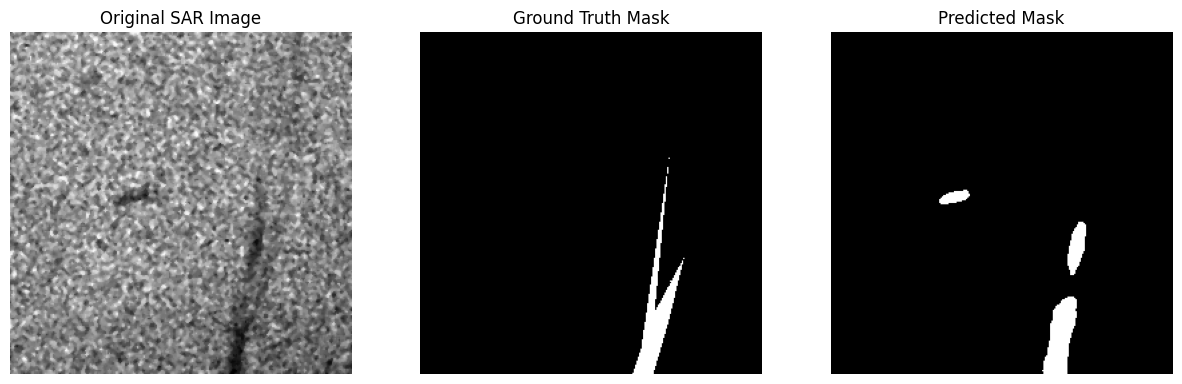

In [ ]:
visualize_side_by_side(test_dataset, model, idx=1)


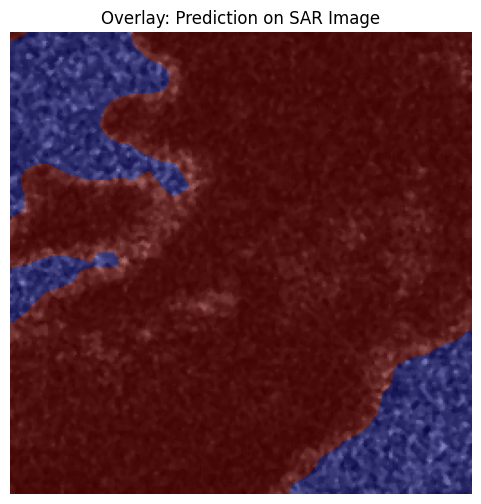

In [ ]:
def overlay_mask(image, mask, alpha=0.5):
    plt.figure(figsize=(6,6))
    plt.imshow(image, cmap="gray")
    plt.imshow(mask, cmap="jet", alpha=alpha)
    plt.title("Overlay: Prediction on SAR Image")
    plt.axis("off")
    plt.show()
img_np = img.squeeze().numpy()
pred_np = predict_mask(model, img)
overlay_mask(img_np, pred_np)


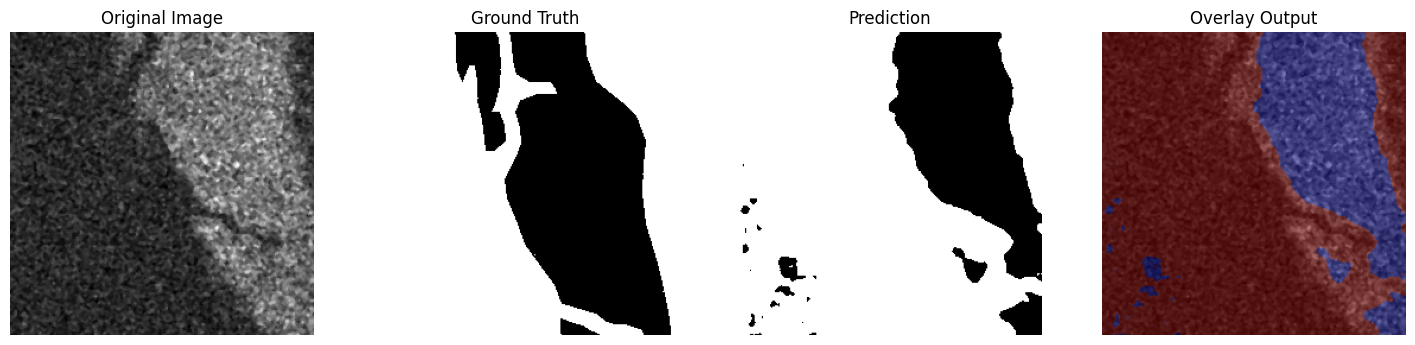

In [ ]:
def visualize_complete(dataset, model, idx):
    img, gt_mask = dataset[idx]

    img_np = img.squeeze().numpy()
    gt_np = gt_mask.squeeze().numpy()
    pred_np = predict_mask(model, img)

    plt.figure(figsize=(18,5))

    plt.subplot(1,4,1)
    plt.imshow(img_np, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1,4,2)
    plt.imshow(gt_np, cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1,4,3)
    plt.imshow(pred_np, cmap='gray')
    plt.title("Prediction")
    plt.axis('off')

    plt.subplot(1,4,4)
    plt.imshow(img_np, cmap='gray')
    plt.imshow(pred_np, cmap='jet', alpha=0.5)
    plt.title("Overlay Output")
    plt.axis('off')

    plt.show()
visualize_complete(test_dataset, model, idx=100)


In [ ]:
#Post processing

In [ ]:
import skimage.morphology as morph

In [ ]:
def post_process(mask, threshold=0.6, min_size=100):
    # Threshold
    mask = (mask > threshold).astype(np.uint8)

    # Morphology
    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Remove small objects
    mask = morph.remove_small_objects(
        mask.astype(bool),
        min_size=min_size
    ).astype(np.uint8)

    return mask


In [ ]:
raw_pred = predict_mask(model, img)   # from your function
refined_pred = post_process(raw_pred)


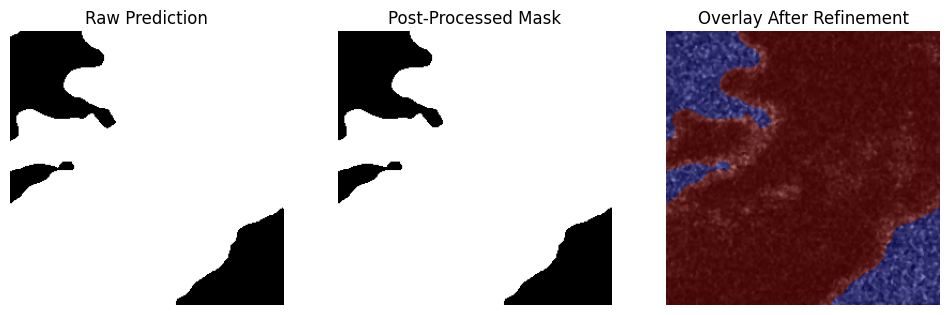

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(raw_pred, cmap="gray")
plt.title("Raw Prediction")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(refined_pred, cmap="gray")
plt.title("Post-Processed Mask")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(img.squeeze(), cmap="gray")
plt.imshow(refined_pred, cmap="jet", alpha=0.5)
plt.title("Overlay After Refinement")
plt.axis("off")

plt.show()


In [ ]:
from google.colab import files
files.download("attention_unet.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>